In [10]:
import torch
import torch.nn as nn        # Pytorch neural network package
import torch.optim as optim  # Pytorch optimization package
import torch.nn.functional as F
import numpy
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda")

In [2]:
features = 64
# define a simple linear VAE #until now normal VAE without Beta
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder 84*84 = 7’056
        self.enc0 = nn.Linear(in_features=84*84, out_features=1024)
        self.enc1 = nn.Linear(in_features=1024, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)
 
        # decoder 
        self.dec0 = nn.Linear(in_features=features, out_features=512)
        self.dec1 = nn.Linear(in_features=512, out_features=1024)
        self.dec2 = nn.Linear(in_features=1024, out_features=84*84)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    
    def encode(self, x):
        x = F.relu(self.enc0(x))
        x = F.relu(self.enc1(x))
        x = self.enc2(x)
        return x

In [3]:
train_data = numpy.load('train_data100kFEB23.npy')
val_data = numpy.load('val_data20kFEB23.npy')

In [4]:
print(train_data.shape)

(101848, 84, 84)


In [5]:
BVAE = LinearVAE()
BVAE.load_state_dict(torch.load('C:/Users/erics/Documents/Programme/Bachelorarbeit/models/BVAE_Pong/B=10VAEFEB25'))
BVAE.to(device)

LinearVAE(
  (enc0): Linear(in_features=7056, out_features=1024, bias=True)
  (enc1): Linear(in_features=1024, out_features=512, bias=True)
  (enc2): Linear(in_features=512, out_features=128, bias=True)
  (dec0): Linear(in_features=64, out_features=512, bias=True)
  (dec1): Linear(in_features=512, out_features=1024, bias=True)
  (dec2): Linear(in_features=1024, out_features=7056, bias=True)
)

In [6]:
randomInput = torch.rand(256, 7056, device=device) #7056 = 84* 84
print(randomInput)


tensor([[0.7871, 0.6382, 0.6075,  ..., 0.0165, 0.2865, 0.7498],
        [0.5389, 0.7998, 0.4932,  ..., 0.2689, 0.2294, 0.6869],
        [0.2451, 0.6344, 0.6155,  ..., 0.0329, 0.8799, 0.7129],
        ...,
        [0.7994, 0.6051, 0.5645,  ..., 0.7637, 0.4685, 0.5589],
        [0.6429, 0.2099, 0.7923,  ..., 0.2906, 0.0955, 0.6630],
        [0.0358, 0.8268, 0.8657,  ..., 0.2295, 0.7350, 0.3277]],
       device='cuda:0')


In [7]:
enco = BVAE.encode(randomInput)
print(enco)

tensor([[-2.4151e-02, -4.0193e-02,  8.0530e-04,  ..., -5.9856e-02,
         -3.9942e+00, -9.7342e+00],
        [ 4.1476e-02, -3.5311e-02, -1.7519e-02,  ..., -3.7422e-03,
         -4.8358e+00, -9.8534e+00],
        [ 3.4652e-02,  2.7614e-02, -3.2955e-02,  ..., -2.3027e-02,
         -4.8241e+00, -9.7071e+00],
        ...,
        [-7.7384e-02, -6.3326e-02, -2.8648e-02,  ..., -3.3008e-02,
         -4.0528e+00, -9.8587e+00],
        [-1.7085e-02, -3.5736e-03,  4.8012e-02,  ..., -4.5892e-02,
         -3.6892e+00, -9.5892e+00],
        [-2.5443e-02,  3.5722e-02,  1.5892e-02,  ...,  3.1083e-03,
         -4.1741e+00, -9.6817e+00]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [12]:
def KLdiv(mu, logvar):
    print(mu.size())
    print((1 + logvar - mu.pow(2) - logvar.exp()).size())
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print(KLD.size())
    return KLD

def compute_gaussian_kl(z_mean, z_logvar):
    return np.mean(0.5 * (np.square(z_mean) + np.exp(z_logvar) - z_logvar - 1), axis=0)

In [17]:
x = enco.view(-1, 2, features)
# get `mu` and `log_var`
mu = x[:, 0, :] # the first feature values as mean
log_var = x[:, 1, :]

KLenco = compute_gaussian_kl(mu.detach().cpu().numpy(), log_var.detach().cpu().numpy())
#print(KLenco.size())
print(KLenco.ndim)

#TODO: Wie macht man dimensionwise KL-divergence??

1


In [24]:
#enco = enco.detach().cpu().numpy()
#KLencoNP = KLenco.detach().cpu().numpy()

In [23]:
print(KLenco.shape)

(64,)


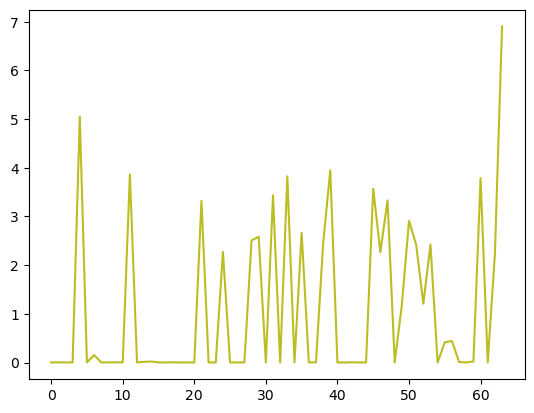

In [21]:
plt.plot(KLenco)
plt.show()

In [30]:
#KLencoMean = numpy.mean(KLenco, axis=0) # in kl_gaussian wird schon mean genommen

In [31]:
#plt.plot(KLencoMean)
#plt.show()

In [28]:
numZero = (numpy.histogram(KLenco, bins=(-0.5, 0.01))[0])/2 #/2 da logvar & mean
print(numZero)

[18.]


In [29]:
Nonzero = 64-numZero
print(Nonzero)

[46.]
